# Entrenamiento de ResNet-18 con todos los conjuntos de MedMNIST

Este cuaderno prepara y entrena un modelo ResNet-18 capaz de clasificar de forma conjunta todos los conjuntos de MedMNIST. El flujo reutiliza el módulo `scripts/entrenar_resnet_general.py`

## Flujo de trabajo
- Importar utilidades y fijar una configuración reproducible
- Listar los datasets disponibles y definir la configuración de entrenamiento
- Preparar los *DataLoaders* combinando todos los conjuntos
- Construir el modelo ResNet-18 y los objetos de optimización
- Entrenar el modelo con seguimiento de métricas por época
- Evaluar en el conjunto de prueba y generar un reporte reutilizable

In [1]:
# Importaciones y configuración básica
import json
from pathlib import Path
from types import SimpleNamespace

import pandas as pd
import torch
from torch.utils.data import DataLoader

from medmnist import INFO

from scripts.Train_RN import (
    crear_cargadores,
    construir_modelo,
    recorrer_entrenamiento,
    evaluar_modelo,
    guardar_reporte,
    construir_scheduler,
    nn,
    Adam,
    ConjuntoGeneralMedMNIST,
)

# Fijamos semillas para reproducibilidad básica
TORCH_SEED = 42
torch.manual_seed(TORCH_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(TORCH_SEED)

print(f"Versión de PyTorch: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

Versión de PyTorch: 2.9.0
CUDA disponible: False


In [2]:
# Listado de datasets 2D de MedMNIST
# Filtramos los que no tienen '3d' en el nombre de su clase de Python
todos_los_datasets = sorted(
    nombre
    for nombre, info in INFO.items()
    if '3d' not in nombre.lower() and '3d' not in info.get('python_class', '').lower()
)
print(f"Total de datasets 2D: {len(todos_los_datasets)}")
todos_los_datasets

Total de datasets 2D: 12


['bloodmnist',
 'breastmnist',
 'chestmnist',
 'dermamnist',
 'octmnist',
 'organamnist',
 'organcmnist',
 'organsmnist',
 'pathmnist',
 'pneumoniamnist',
 'retinamnist',
 'tissuemnist']

In [3]:
# Configuración centralizada; ajusta hiperparámetros aquí
config = SimpleNamespace(
    datasets=todos_los_datasets,
    epocas=5,  # Incrementa si quieres un entrenamiento más largo
    tamano_lote=256,
    tasa_aprendizaje=1e-3,
    decaimiento_peso=1e-4,
    tamano_imagen=28,
    usar_aumentos=True,
    descargar=True,
    sin_preentrenar=False,
    dispositivo="cuda" if torch.cuda.is_available() else "cpu",
    salida="resultados/reporte_resnet18_todos.json",
    trabajadores=4,
    scheduler="plateau",
    factor_scheduler=0.5,
    paciencia_scheduler=3,
)
config

namespace(datasets=['bloodmnist',
                    'breastmnist',
                    'chestmnist',
                    'dermamnist',
                    'octmnist',
                    'organamnist',
                    'organcmnist',
                    'organsmnist',
                    'pathmnist',
                    'pneumoniamnist',
                    'retinamnist',
                    'tissuemnist'],
          epocas=5,
          tamano_lote=256,
          tasa_aprendizaje=0.001,
          decaimiento_peso=0.0001,
          tamano_imagen=28,
          usar_aumentos=True,
          descargar=True,
          sin_preentrenar=False,
          dispositivo='cpu',
          salida='resultados/reporte_resnet18_todos.json',
          trabajadores=4,
          scheduler='plateau',
          factor_scheduler=0.5,
          paciencia_scheduler=3)

## Preparar *DataLoaders* combinando todos los conjuntos

In [4]:
(
    loader_entrenamiento,
    loader_validacion,
    loader_prueba,
    info_datasets,
) = crear_cargadores(
    nombres_dataset=config.datasets,
    tamano_lote=config.tamano_lote,
    descarga=config.descargar,
    tamano_imagen=config.tamano_imagen,
    usar_aumentos=config.usar_aumentos,
    trabajadores=config.trabajadores,
)

resumen_datos = {
    "train": len(loader_entrenamiento.dataset),
    "test": len(loader_prueba.dataset),
}
if loader_validacion is not None:
    resumen_datos["val"] = len(loader_validacion.dataset)

print("Resumen de muestras por partición:", resumen_datos)

total_clases = sum(info.clases for info in info_datasets.values())
print("Total de clases combinadas:", total_clases)

info_datasets

Resumen de muestras por partición: {'train': 518175, 'test': 119320, 'val': 70467}
Total de clases combinadas: 92


{'bloodmnist': RegistroDataset(nombre='bloodmnist', indice_inicial=0, clases=8),
 'breastmnist': RegistroDataset(nombre='breastmnist', indice_inicial=8, clases=2),
 'chestmnist': RegistroDataset(nombre='chestmnist', indice_inicial=10, clases=14),
 'dermamnist': RegistroDataset(nombre='dermamnist', indice_inicial=24, clases=7),
 'octmnist': RegistroDataset(nombre='octmnist', indice_inicial=31, clases=4),
 'organamnist': RegistroDataset(nombre='organamnist', indice_inicial=35, clases=11),
 'organcmnist': RegistroDataset(nombre='organcmnist', indice_inicial=46, clases=11),
 'organsmnist': RegistroDataset(nombre='organsmnist', indice_inicial=57, clases=11),
 'pathmnist': RegistroDataset(nombre='pathmnist', indice_inicial=68, clases=9),
 'pneumoniamnist': RegistroDataset(nombre='pneumoniamnist', indice_inicial=77, clases=2),
 'retinamnist': RegistroDataset(nombre='retinamnist', indice_inicial=79, clases=5),
 'tissuemnist': RegistroDataset(nombre='tissuemnist', indice_inicial=84, clases=8)}

## Construir modelo, criterio de pérdida y optimizador

In [5]:
dispositivo = torch.device(config.dispositivo)
print(f"Usando dispositivo: {dispositivo}")

modelo = construir_modelo(
    total_clases=total_clases,
    usar_pesos_imagenet=not config.sin_preentrenar,
)
modelo = modelo.to(dispositivo)

criterio = nn.CrossEntropyLoss()
optimizador = Adam(
    modelo.parameters(),
    lr=config.tasa_aprendizaje,
    weight_decay=config.decaimiento_peso,
)
scheduler = construir_scheduler(
    optimizador=optimizador,
    tipo_scheduler=config.scheduler,
    factor=config.factor_scheduler,
    paciencia=config.paciencia_scheduler,
)

modelo

Usando dispositivo: cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Entrenar el modelo

In [6]:
historial_entrenamiento, mejor_estado = recorrer_entrenamiento(
    modelo=modelo,
    cargador_entrenamiento=loader_entrenamiento,
    cargador_validacion=loader_validacion,
    criterio=criterio,
    optimizador=optimizador,
    scheduler=scheduler,
    epocas=config.epocas,
    dispositivo=dispositivo,
)

# Si hubo mejora en validación, recargamos el mejor estado
if mejor_estado:
    modelo.load_state_dict(mejor_estado)

historial_entrenamiento[:3]

/Users/matgoni/.venvs/global/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoca 001] Perdida ent: 0.9901 | Exactitud ent: 0.6678 | Perdida val: 0.9301 | Exactitud val: 0.6798
[Epoca 002] Perdida ent: 0.8537 | Exactitud ent: 0.7101 | Perdida val: 0.8964 | Exactitud val: 0.7047
[Epoca 003] Perdida ent: 0.8133 | Exactitud ent: 0.7243 | Perdida val: 0.8229 | Exactitud val: 0.7213
[Epoca 004] Perdida ent: 0.7891 | Exactitud ent: 0.7319 | Perdida val: 0.8064 | Exactitud val: 0.7311
[Epoca 005] Perdida ent: 0.7713 | Exactitud ent: 0.7378 | Perdida val: 0.8230 | Exactitud val: 0.7171


[{'epoca': 1,
  'perdida_entrenamiento': 0.9901418965795816,
  'exactitud_entrenamiento': 0.667843875138708,
  'perdida_validacion': 0.930087148103667,
  'exactitud_validacion': 0.6798075695006173},
 {'epoca': 2,
  'perdida_entrenamiento': 0.8536893544127145,
  'exactitud_entrenamiento': 0.7101114488348531,
  'perdida_validacion': 0.89644318852288,
  'exactitud_validacion': 0.7047270353498801},
 {'epoca': 3,
  'perdida_entrenamiento': 0.8133121269493584,
  'exactitud_entrenamiento': 0.7243267235972403,
  'perdida_validacion': 0.8228592586924697,
  'exactitud_validacion': 0.721302169809982}]

## Historial de métricas por época

In [7]:
df_historial = pd.DataFrame(historial_entrenamiento)
df_historial

,epoca,perdida_entrenamiento,exactitud_entrenamiento,perdida_validacion,exactitud_validacion
0,1,0.990142,0.667844,0.930087,0.679808
1,2,0.853689,0.710111,0.896443,0.704727
2,3,0.813312,0.724327,0.822859,0.721302
3,4,0.789114,0.731923,0.806370,0.731051
4,5,0.771323,0.737803,0.823017,0.717102


## Evaluación en el conjunto de prueba

In [8]:
perdida_test, exactitud_test, metricas_por_dataset = evaluar_modelo(
    modelo,
    loader_prueba,
    criterio,
    dispositivo,
)

print(f"Exactitud global en test: {exactitud_test:.4f}")
print(f"Pérdida global en test: {perdida_test:.4f}")

filas = []
for nombre, datos in metricas_por_dataset.items():
    filas.append(
        {
            "dataset": nombre,
            "exactitud": datos.get("exactitud", 0.0),
            "ejemplos": int(datos.get("ejemplos", 0)),
            "offset": info_datasets[nombre].indice_inicial,
            "clases": info_datasets[nombre].clases,
        }
    )

df_metricas = pd.DataFrame(filas).sort_values("exactitud", ascending=False)
df_metricas

/Users/matgoni/.venvs/global/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Exactitud global en test: 0.6611
Pérdida global en test: 1.0368


,dataset,exactitud,ejemplos,offset,clases
0,bloodmnist,0.856475,3421,0,8
5,organamnist,0.837721,17778,35,11
9,pneumoniamnist,0.831731,624,77,2
8,pathmnist,0.828552,7180,68,9
1,breastmnist,0.737179,156,8,2
3,dermamnist,0.706733,2005,24,7
4,octmnist,0.653000,1000,31,4
2,chestmnist,0.636963,22433,10,14
6,organcmnist,0.623174,8216,46,11
7,organsmnist,0.602696,8827,57,11


## Guardar reporte y revisar el resultado

## Matriz de confusión

Generamos una matriz de confusión para cada dataset individual, normalizada por filas, tomando las predicciones del modelo en el conjunto de prueba.

/Users/matgoni/.venvs/global/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


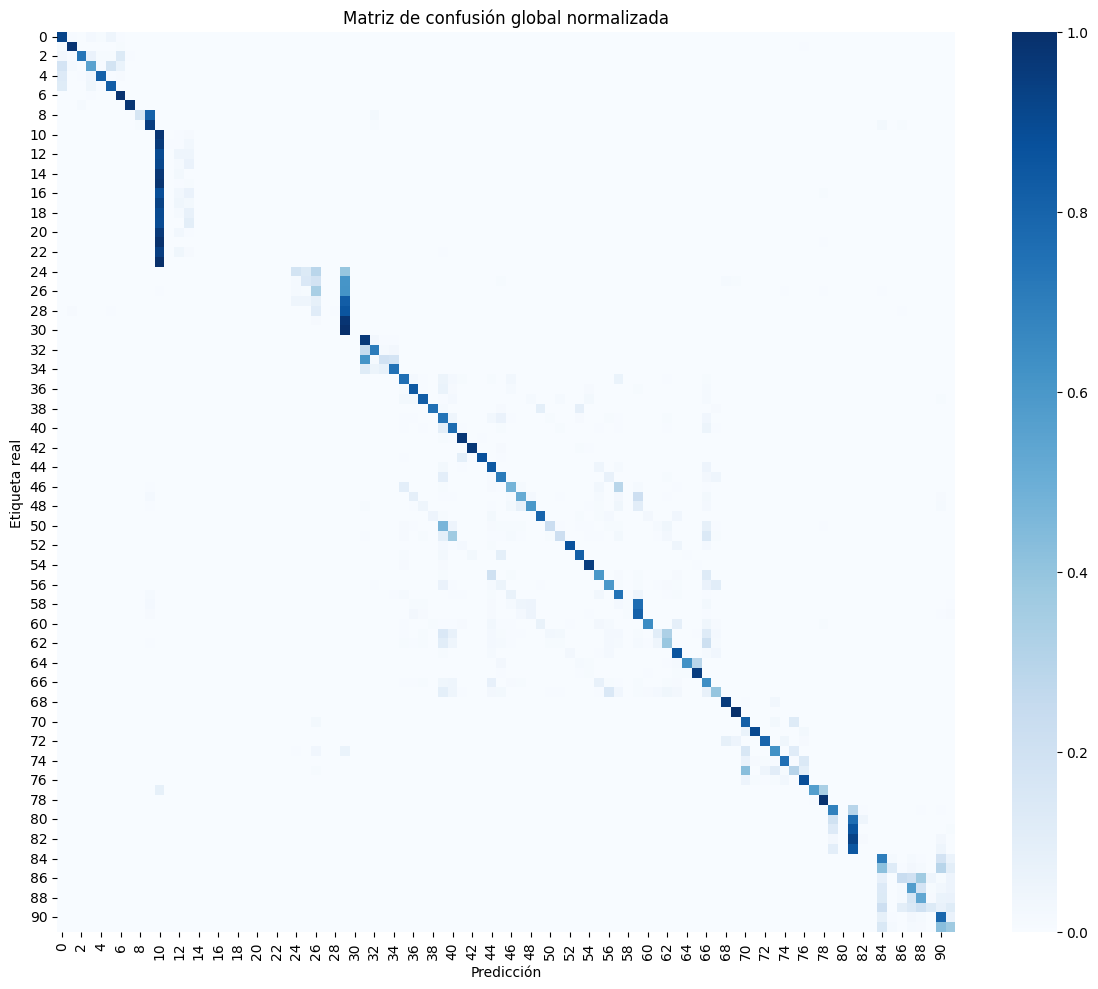

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Recolectar todas las etiquetas y predicciones juntas
y_true, y_pred = [], []
modelo.eval()
with torch.no_grad():
    for imagenes, etiquetas, _ in loader_prueba:
        salidas = modelo(imagenes.to(dispositivo))
        pred = salidas.argmax(dim=1).cpu().numpy()
        y_true.extend(etiquetas.numpy())
        y_pred.extend(pred)

cm_global = confusion_matrix(y_true, y_pred, normalize="true")
plt.figure(figsize=(12, 10))
sns.heatmap(cm_global, cmap="Blues")
plt.title("Matriz de confusión global normalizada")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


In [9]:
metricas_reporte = {
    "perdida": perdida_test,
    "exactitud": exactitud_test,
    "detalle_por_dataset": df_metricas.set_index("dataset")[['exactitud', 'ejemplos']].to_dict(orient="index"),
}

ruta_reporte = Path(config.salida)

guardar_reporte(
    ruta_salida=ruta_reporte,
    argumentos=config,
    historial=historial_entrenamiento,
    metricas_prueba=metricas_reporte,
    informacion_datasets=info_datasets,
)

print(f"Reporte guardado en: {ruta_reporte.resolve()}")

with ruta_reporte.open("r", encoding="utf-8") as archivo:
    resumen = json.load(archivo)
resumen.keys()

Reporte guardado en: /Users/matgoni/Projects/ModeloGeneral-MedMNIST/resultados/reporte_resnet18_todos.json


dict_keys(['fecha', 'configuracion', 'historial_epocas', 'metricas_prueba', 'datasets'])

## Evaluación Leave-One-Domain-Out (LODO)

Para estimar la capacidad de generalización a dominios no vistos, entrenamos el modelo excluyendo cada dataset 2D de MedMNIST por turno y evaluamos exclusivamente en el dominio dejado fuera.

In [13]:
# Cálculo de offsets y total de clases globales para mantener un espacio de etiquetas coherente

def obtener_numero_clases(nombre: str) -> int:
    info = INFO[nombre]
    if "n_classes" in info:
        return int(info["n_classes"])
    etiquetas = info.get("label")
    if isinstance(etiquetas, dict) and etiquetas:
        return len(etiquetas)
    raise ValueError(f"No se puede inferir el número de clases para {nombre}")

mapa_clases = {nombre: obtener_numero_clases(nombre) for nombre in todos_los_datasets}
mapa_offsets_global = {}
acumulado = 0
for nombre in todos_los_datasets:
    mapa_offsets_global[nombre] = acumulado
    acumulado += mapa_clases[nombre]

total_clases_global = acumulado
print(f"Total de clases globales (2D): {total_clases_global}")

Total de clases globales (2D): 92


In [14]:
from copy import deepcopy
try:
    from tqdm.auto import tqdm
except ImportError:  # pragma: no cover
    def tqdm(iterable, **kwargs):
        return iterable

resultados_lodo = []

for dataset_excluido in tqdm(todos_los_datasets, desc="LODO", leave=False):
    datasets_entrenamiento = [d for d in todos_los_datasets if d != dataset_excluido]

    loader_entrenamiento_lodo, loader_validacion_lodo, _, _ = crear_cargadores(
        nombres_dataset=datasets_entrenamiento,
        tamano_lote=config.tamano_lote,
        descarga=config.descargar,
        tamano_imagen=config.tamano_imagen,
        usar_aumentos=config.usar_aumentos,
        trabajadores=config.trabajadores,
        mapa_offsets=mapa_offsets_global,
        total_clases_global=total_clases_global,
    )

    conjunto_prueba_holdout = ConjuntoGeneralMedMNIST(
        nombres_dataset=[dataset_excluido],
        split="test",
        descarga=config.descargar,
        tamano_imagen=config.tamano_imagen,
        usar_aumentos=False,
        mapa_offsets=mapa_offsets_global,
        total_clases_global=total_clases_global,
    )
    loader_prueba_holdout = DataLoader(
        conjunto_prueba_holdout,
        batch_size=config.tamano_lote,
        shuffle=False,
        num_workers=config.trabajadores,
        pin_memory=True,
    )

    modelo_lodo = construir_modelo(
        total_clases=total_clases_global,
        usar_pesos_imagenet=not config.sin_preentrenar,
    ).to(dispositivo)

    criterio_lodo = nn.CrossEntropyLoss()
    optimizador_lodo = Adam(
        modelo_lodo.parameters(),
        lr=config.tasa_aprendizaje,
        weight_decay=config.decaimiento_peso,
    )
    scheduler_lodo = construir_scheduler(
        optimizador=optimizador_lodo,
        tipo_scheduler=config.scheduler,
        factor=config.factor_scheduler,
        paciencia=config.paciencia_scheduler,
    )

    historial_lodo, mejor_estado_lodo = recorrer_entrenamiento(
        modelo=modelo_lodo,
        cargador_entrenamiento=loader_entrenamiento_lodo,
        cargador_validacion=loader_validacion_lodo,
        criterio=criterio_lodo,
        optimizador=optimizador_lodo,
        scheduler=scheduler_lodo,
        epocas=config.epocas,
        dispositivo=dispositivo,
    )

    if mejor_estado_lodo:
        modelo_lodo.load_state_dict(mejor_estado_lodo)

    perdida_holdout, exactitud_holdout, metricas_holdout = evaluar_modelo(
        modelo_lodo,
        loader_prueba_holdout,
        criterio_lodo,
        dispositivo,
    )

    detalle = metricas_holdout.get(dataset_excluido, {})
    resultados_lodo.append(
        {
            "dataset_holdout": dataset_excluido,
            "exactitud_holdout": detalle.get("exactitud", exactitud_holdout),
            "perdida_holdout": perdida_holdout,
            "epocas": config.epocas,
            "tamano_lote": config.tamano_lote,
        }
    )

TypeError: crear_cargadores() got an unexpected keyword argument 'mapa_offsets'

In [ ]:
df_lodo = pd.DataFrame(resultados_lodo).sort_values("exactitud_holdout", ascending=False)
df_lodo